In [57]:
import numpy as np

import sys
import os

os.environ['TOOLBOX_PATH'] = "/PATH/TO/BART/"
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python/")
sys.path.append("PATH/TO/TOOLS/")

import struct
import cfl

from copy import deepcopy

from matplotlib import pyplot as plt
from matplotlib import lines as lines
from matplotlib import colors as col
from matplotlib import patches as patches
%matplotlib inline

import toolbox as tools

import pickle5 as pickle
import skimage
import nibabel as nib

In [2]:
figure_folder = 'Saved_Figures/'

In [3]:
data = np.load('path/to/data.npy',allow_pickle=True).item()

In [4]:
params = {}
params['TGV'] = [0.00001,0.00002,0.00005,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1]
params['TV'] = [0.00001,0.00002,0.00005,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1]
params['LLR'] = [0.00001,0.00002,0.00005,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1]
params['L2'] = [0,0.00001,0.0001,0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2]


In [5]:
# Pre-process data

area_maxnorm = 0
motion_maxnorm = 0

for reg in data.keys():
    
    data[reg]['area_norm'] = data[reg]['area']-np.mean(data[reg]['area'],1)[...,np.newaxis]
    area_maxnorm = np.maximum(np.max(np.abs(data[reg]['area_norm']),(0,1)),area_maxnorm)
    motion_maxnorm = np.maximum(np.max(np.abs(data[reg]['motion']),(0,1)),motion_maxnorm)
    
    
for reg in data.keys():
    data[reg]['area_norm'] = data[reg]['area_norm']/area_maxnorm
    data[reg]['motion_norm'] = data[reg]['motion']/motion_maxnorm
    
    

In [6]:
ref_area = (data['TGV']['area'][0]+data['TV']['area'][0])/2
ref_area_norm = (ref_area - np.mean(ref_area))/area_maxnorm

ref_area = data['L2']['area'][0]
ref_area_norm = (ref_area - np.mean(ref_area))/area_maxnorm

ref_motion = (data['TGV']['motion'][0]+data['TV']['motion'][0]+data['LLR']['motion'][2])/3
ref_motion_norm = ref_motion/motion_maxnorm

ref_motion = data['L2']['motion'][0]
ref_motion_norm = ref_motion/motion_maxnorm

Text(0.5, 1.0, 'LLR')

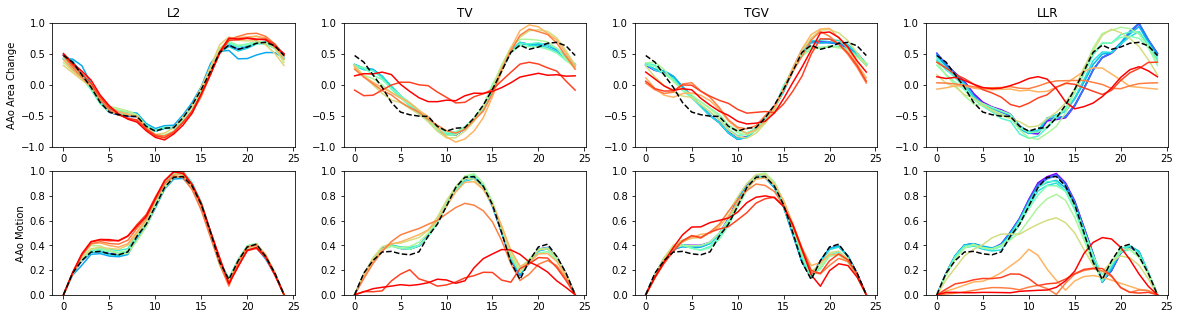

In [48]:
f, a = plt.subplots(2, 4, figsize=(20, 5))

area = 'area_norm'
motion = 'motion_norm'

colormap = plt.get_cmap('rainbow')(np.linspace(0,1,data['L2']['area'].shape[0]))
a[0,0].set_prop_cycle(cycler('color', colormap))
a[0,0].plot(data['L2'][area].transpose());

a[1,0].set_prop_cycle(cycler('color', colormap))
a[1,0].plot(data['L2'][motion].transpose());

colormap = plt.get_cmap('rainbow')(np.linspace(0,1,data['LLR']['area'].shape[0]))
a[0,1].set_prop_cycle(cycler('color', colormap))
a[0,1].plot(data['TV'][area].transpose());
a[0,2].set_prop_cycle(cycler('color', colormap))
a[0,2].plot(data['TGV'][area].transpose());
a[0,3].set_prop_cycle(cycler('color', colormap))
a[0,3].plot(data['LLR'][area].transpose());

a[1,1].set_prop_cycle(cycler('color', colormap))
a[1,1].plot(data['TV'][motion].transpose());
a[1,2].set_prop_cycle(cycler('color', colormap))
a[1,2].plot(data['TGV'][motion].transpose());
a[1,3].set_prop_cycle(cycler('color', colormap))
a[1,3].plot(data['LLR'][motion].transpose());

[_.plot(ref_area_norm,'k--') for _ in a[0,:].flatten()];
[_.plot(ref_motion_norm,'k--') for _ in a[1,:].flatten()];

[_.set_ylim([-1,1]) for _ in a[0,:].flatten()];
[_.set_ylim([0,1]) for _ in a[1,:].flatten()];

a[0,0].set_ylabel('AAo Area Change')
a[1,0].set_ylabel('AAo Motion')

a[0,0].set_title('L2')
a[0,1].set_title('TV')
a[0,2].set_title('TGV')
a[0,3].set_title('LLR')

#plt.savefig(figure_folder+'AAocurves.png',dpi=1000,bbox_inches='tight')


In [46]:
# Metrics

metrics = {}

metrics['motion_RMSE'] = {}
metrics['area_norm_RMSE'] = {}
metrics['area_RMSE'] = {}

metrics['motion_mag'] = {}
metrics['area_mag'] = {}

for reg in data.keys():
    metrics['motion_RMSE'][reg] = []
    metrics['area_RMSE'][reg] = []
    metrics['area_norm_RMSE'][reg] = []
    metrics['motion_mag'][reg] = []
    metrics['area_mag'][reg] = []
    
    for idx in range(data[reg]['area'].shape[0]):
        
        RMSE_area = np.sqrt(np.mean((data[reg]['area'][idx]-ref_area)**2))
        RMSE_area_norm = np.sqrt(np.mean((data[reg]['area_norm'][idx]-ref_area_norm)**2))
        RMSE_motion = np.sqrt(np.mean((data[reg]['motion_norm'][idx]-ref_motion_norm)**2))
        
        motion_mag = np.max(data[reg]['motion'][idx])
        area_mag = np.max(data[reg]['area'][idx]) - np.min(data[reg]['area'][idx])
           
           
        metrics['area_RMSE'][reg].append(RMSE_area)
        metrics['area_norm_RMSE'][reg].append(RMSE_area_norm)
        metrics['motion_RMSE'][reg].append(RMSE_motion)
        
        metrics['motion_mag'][reg].append(motion_mag)
        metrics['area_mag'][reg].append(area_mag)

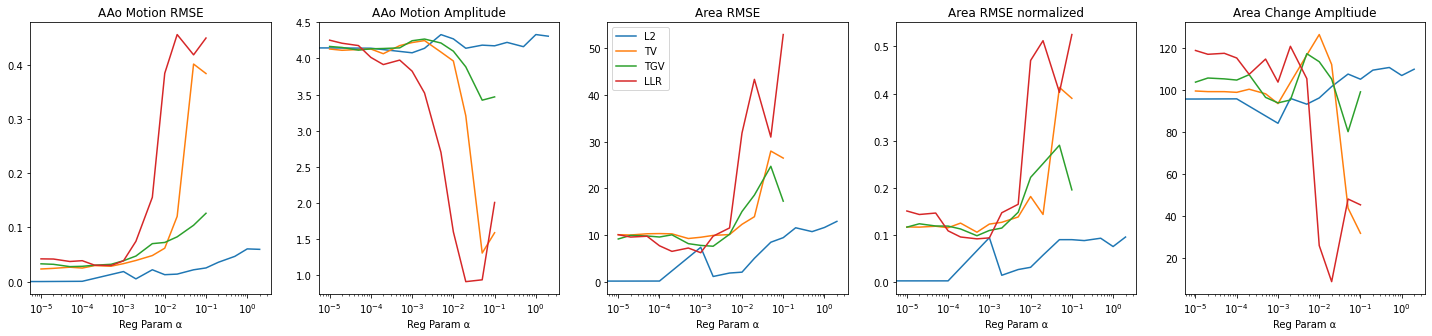

In [9]:
f, a = plt.subplots(1, 5, figsize=(25, 5))

reg_order = ['L2','TV','TGV','LLR']

for reg in reg_order:
    
    a[0].semilogx(params[reg],metrics['motion_RMSE'][reg])
    a[1].semilogx(params[reg],metrics['motion_mag'][reg])
    
    a[2].semilogx(params[reg],metrics['area_RMSE'][reg])
    a[3].semilogx(params[reg],metrics['area_norm_RMSE'][reg])
    a[4].semilogx(params[reg],metrics['area_mag'][reg])

a[2].legend(reg_order,loc=2)

a[0].set_title('AAo Motion RMSE')
a[1].set_title('AAo Motion Amplitude')
a[2].set_title('Area RMSE')
a[3].set_title('Area RMSE normalized')
a[4].set_title('Area Change Ampltiude')

[_.set_xlabel('Reg Param ⍺') for _ in a.flatten()];

#plt.savefig(figure_folder+'AAoregcurves.png',dpi=1000,bbox_inches='tight')

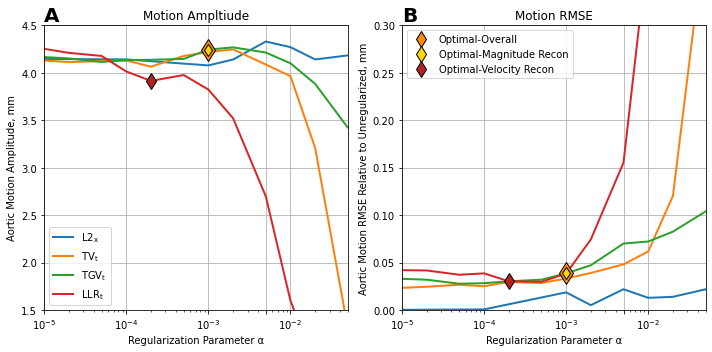

In [75]:
f, a = plt.subplots(1, 2, figsize=(10, 5))

lw = 2

for reg in reg_order:
    a[0].semilogx(params[reg],metrics['motion_mag'][reg],lw=lw)
    a[1].semilogx(params[reg],metrics['motion_RMSE'][reg],lw=lw)

a[0].set_xlim([1e-5,5e-2])
a[0].set_ylim([1.5,4.5])

a[1].set_xlim([1e-5,5e-2])
a[1].set_ylim([0,0.3])

a[0].legend(['$\mathregular{L2_x}$','$\mathregular{TV_t}$','$\mathregular{TGV_t}$','$\mathregular{LLR_t}$','$\mathregular{+ Median_t}$'],loc=3)

mstyle = 'd'
msize=12

mcolors = ['darkorange','gold','firebrick']

ind_p1 = 6
a[0].plot(params['TGV'][ind_p1], metrics['motion_mag']['TGV'][ind_p1],mstyle,color = mcolors[0],markersize=msize+4,markeredgecolor='k')
a[1].plot(params['TGV'][ind_p1], metrics['motion_RMSE']['TGV'][ind_p1],mstyle,color = mcolors[0],markersize=msize+4,markeredgecolor='k')

ind_p2 = 6
a[0].plot(params['TGV'][ind_p2], metrics['motion_mag']['TGV'][ind_p2],mstyle,color = mcolors[1],markersize=msize-3,markeredgecolor='k')
a[1].plot(params['TGV'][ind_p2], metrics['motion_RMSE']['TGV'][ind_p2],mstyle,color = mcolors[1],markersize=msize-3,markeredgecolor='k')

ind_p3 = 4
a[0].plot(params['LLR'][ind_p3], metrics['motion_mag']['LLR'][ind_p3],mstyle,color = mcolors[2],markersize=msize,markeredgecolor='k')
a[1].plot(params['LLR'][ind_p3], metrics['motion_RMSE']['LLR'][ind_p3],mstyle,color = mcolors[2],markersize=msize,markeredgecolor='k')


custom_markers = [lines.Line2D([0], [0], color=mcolors[0], lw=lw, linestyle = 'None', marker= 'd',markersize=msize,markeredgecolor='k'),
                  lines.Line2D([0], [0], color=mcolors[1], lw=lw, linestyle = 'None', marker= 'd',markersize=msize,markeredgecolor='k'),
                  lines.Line2D([0], [0], color=mcolors[2], lw=lw, linestyle = 'None', marker= 'd',markersize=msize,markeredgecolor='k')]
a[1].legend(custom_markers, ['Optimal-Overall','Optimal-Magnitude Recon','Optimal-Velocity Recon'],loc=2)

a[0].set_xticks([1e-5,1e-4,1e-3,5e-3,1e-2])
a[0].grid()

a[1].set_xticks([1e-5,1e-4,1e-3,5e-3,1e-2])
a[1].grid()

a[0].set_ylabel('Aortic Motion Amplitude, mm');
a[1].set_ylabel('Aortic Motion RMSE Relative to Unregularized, mm');
a[0].set_xlabel('Regularization Parameter α')
a[1].set_xlabel('Regularization Parameter α')

a[0].text(1e-5,4.5,'A',rotation='horizontal', verticalalignment='bottom',horizontalalignment='left',fontweight='semibold',fontsize=20,c = 'k');
a[1].text(1e-5,0.3,'B',rotation='horizontal', verticalalignment='bottom',horizontalalignment='left',fontweight='semibold',fontsize=20,c = 'k');

a[0].set_title('Motion Ampltiude')
a[1].set_title('Motion RMSE')
f.tight_layout()

plt.savefig('Supplement/Motion_Curves.png',dpi=1000,bbox_inches='tight')